In [244]:
pip install textblob

Note: you may need to restart the kernel to use updated packages.


In [245]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import re

<h1>Web Scraping </h1>

In [246]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL and pagination setup
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10  # Number of pages to scrape
page_size = 100  # Number of reviews per page

# Initialize lists to store data
reviews = []
aircrafts = []
seat_types = []
routes = []
recommended = []
rating_data = []

# Scrape reviews from multiple pages
for i in range(1, pages + 1):
    print(f"Scraping page {i}")

    # Create URL for the current page
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Get HTML content
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve data from page {i}")
        continue

    # Parse HTML content
    parsed_content = BeautifulSoup(response.content, 'html.parser')

    # Extract reviews
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text(strip=True))

    # Extract additional information
    for review_stats in parsed_content.find_all("div", {"class": "review-stats"}):
        rating = []
        for value_td in review_stats.find_all('td', {'class': 'review-value'}):
            rating.append(value_td.get_text(strip=True))
        
        if rating:
            # Extract recommended info
            recommended.append(rating.pop(-1))
        else:
            recommended.append("")  # Ensure consistent length

        for star_td in review_stats.find_all('td', {'class': 'review-rating-stars stars'}):
            stars = len(star_td.find_all('span', {'class': 'star fill'}))
            rating.append(stars)
        
        categories = []
        for header_td in review_stats.find_all('td', {'class': 'review-rating-header'}):
            categories.append(header_td.get_text(strip=True))
        
        # Create the record from both lists, using zip
        rating_dict = dict(zip(categories, rating))
        rating_data.append(rating_dict)

    # Extract aircraft, seat type, and route information if available
    for info in parsed_content.find_all("div", {"class": "review-header"}):
        aircraft_div = info.find("div", {"class": "review-attr-item aircraft"})
        aircraft = aircraft_div.get_text(strip=True) if aircraft_div else ""
        aircrafts.append(aircraft)
        
        seat_div = info.find("div", {"class": "review-attr-item seat_type"})
        seat_type = seat_div.get_text(strip=True) if seat_div else ""
        seat_types.append(seat_type)
        
        route_div = info.find("div", {"class": "review-attr-item route"})
        route = route_div.get_text(strip=True) if route_div else ""
        routes.append(route)
    
    print(f"   ---> {len(reviews)} total reviews")

# Ensure all lists are of the same length
max_length = max(len(reviews), len(aircrafts), len(seat_types), len(routes), len(recommended))
reviews.extend([""] * (max_length - len(reviews)))
aircrafts.extend([""] * (max_length - len(aircrafts)))
seat_types.extend([""] * (max_length - len(seat_types)))
routes.extend([""] * (max_length - len(routes)))
recommended.extend([""] * (max_length - len(recommended)))

# Combine all data into a DataFrame
df = pd.DataFrame({
    'reviews': reviews,
    'aircraft': aircrafts,
    'seat_type': seat_types,
    'route': routes,
    'recommended': recommended
})

# Add rating data if available
if rating_data:
    ratings_df = pd.DataFrame(rating_data)
    
    # Explicitly cast non-string columns to compatible types before filling NaN
    for col in ratings_df.select_dtypes(include=['float', 'int']).columns:
        ratings_df[col] = ratings_df[col].astype(pd.Int64Dtype()).fillna(pd.NA)
    for col in ratings_df.select_dtypes(include=['object']).columns:
        ratings_df[col] = ratings_df[col].fillna("")
    
    df = pd.concat([df, ratings_df], axis=1)

# Save DataFrame to CSV
csv_filename = 'british_airways_reviews.csv'
df.to_csv(csv_filename, index=False)

print(f"Data saved to {csv_filename}")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Data saved to british_airways_reviews.csv


In [247]:
ba_review = pd.read_csv('british_airways_reviews.csv')
display(ba_review.head())

,reviews,aircraft,seat_type,route,recommended,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Aircraft
0,"Not Verified| On March 1st, I flew from Berl...",NaN,NaN,NaN,no,Business,Economy Class,Berlin to São Paulo via London,March 2024,3.0,4.0,3.0,3.0,1.0,3.0,2,NaN
1,Not Verified| The WORST customer experience! B...,NaN,NaN,NaN,no,Couple Leisure,Economy Class,London to Corfu,September 2023,1.0,1.0,NaN,NaN,1.0,NaN,1,NaN
2,Not Verified| Had to cancel my flight months...,NaN,NaN,NaN,no,Solo Leisure,Economy Class,Toronto to London,July 2024,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
3,✅Trip Verified| Flight cancelled with no reaso...,NaN,NaN,NaN,no,Couple Leisure,Economy Class,London Gatwick to Verona,June 2024,1.0,1.0,1.0,1.0,1.0,1.0,1,NaN
4,✅Trip Verified| This is a route I fly regularl...,NaN,NaN,NaN,yes,Business,Business Class,London Heathrow to Paris CDG,June 2024,4.0,5.0,3.0,NaN,1.0,NaN,3,A320


In [248]:
remove_text = ['✅Trip Verified', 'Not Verified']

# Apply the replacements directly on the 'reviews' column
for text in remove_text:
    ba_review['reviews'] = ba_review['reviews'].str.replace(text, '', regex=False)

# Display the first few rows to confirm the changes
display(ba_review.head())


,reviews,aircraft,seat_type,route,recommended,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Ground Service,Wifi & Connectivity,Value For Money,Aircraft
0,"| On March 1st, I flew from Berlin to São Pa...",NaN,NaN,NaN,no,Business,Economy Class,Berlin to São Paulo via London,March 2024,3.0,4.0,3.0,3.0,1.0,3.0,2,NaN
1,| The WORST customer experience! British Airwa...,NaN,NaN,NaN,no,Couple Leisure,Economy Class,London to Corfu,September 2023,1.0,1.0,NaN,NaN,1.0,NaN,1,NaN
2,| Had to cancel my flight months in advance ...,NaN,NaN,NaN,no,Solo Leisure,Economy Class,Toronto to London,July 2024,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
3,| Flight cancelled with no reason given less t...,NaN,NaN,NaN,no,Couple Leisure,Economy Class,London Gatwick to Verona,June 2024,1.0,1.0,1.0,1.0,1.0,1.0,1,NaN
4,| This is a route I fly regularly. Used first ...,NaN,NaN,NaN,yes,Business,Business Class,London Heathrow to Paris CDG,June 2024,4.0,5.0,3.0,NaN,1.0,NaN,3,A320


In [249]:
# Number of Rows and Columns
num_rows, num_cols = ba_review.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

# Data Type
print("\nData types of each column:")
print(ba_review.dtypes)

Number of rows: 1000
Number of columns: 17

Data types of each column:
reviews                    object
aircraft                  float64
seat_type                 float64
route                     float64
recommended                object
Type Of Traveller          object
Seat Type                  object
Route                      object
Date Flown                 object
Seat Comfort              float64
Cabin Staff Service       float64
Food & Beverages          float64
Inflight Entertainment    float64
Ground Service            float64
Wifi & Connectivity       float64
Value For Money             int64
Aircraft                   object
dtype: object


In [250]:
# List of columns to remove due to the fact they would not be needed for my report or analysis question
columnstoremove = ['aircraft','Type Of Traveller','seat_type','route','Route','Ground Service','Aircraft','Date Flown']
# Remove columns
ba_review = ba_review.drop(columns=columnstoremove)

In [251]:
display(ba_review.head(2))

,reviews,recommended,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Wifi & Connectivity,Value For Money
0,"| On March 1st, I flew from Berlin to São Pa...",no,Economy Class,3.0,4.0,3.0,3.0,3.0,2
1,| The WORST customer experience! British Airwa...,no,Economy Class,1.0,1.0,NaN,NaN,NaN,1


<p>The ratings can only be 1-5 hence removing all numbers less that 1 in each heading</p>

In [252]:
# Columns to clean
columns_to_clean = ['Value For Money', 'Seat Comfort', 'Cabin Staff Service', 
                    'Food & Beverages', 'Inflight Entertainment', 'Wifi & Connectivity']

# Function to remove numbers less than 1
def remove_less_than_1(value):
    try:
        if float(value) < 1:
            return ''
        else:
            return value
    except ValueError:
        return value

# Apply the function to each cell in the specified columns using map
ba_review[columns_to_clean] = ba_review[columns_to_clean].applymap(remove_less_than_1)

# Display the first few rows to confirm the changes
display(ba_review.head())

C:\Users\Oluwaferanmi\AppData\Local\Temp\ipykernel_4484\2009109972.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ba_review[columns_to_clean] = ba_review[columns_to_clean].applymap(remove_less_than_1)


,reviews,recommended,Seat Type,Seat Comfort,Cabin Staff Service,Food & Beverages,Inflight Entertainment,Wifi & Connectivity,Value For Money
0,"| On March 1st, I flew from Berlin to São Pa...",no,Economy Class,3.0,4.0,3.0,3.0,3.0,2
1,| The WORST customer experience! British Airwa...,no,Economy Class,1.0,1.0,NaN,NaN,NaN,1
2,| Had to cancel my flight months in advance ...,no,Economy Class,NaN,NaN,NaN,NaN,NaN,1
3,| Flight cancelled with no reason given less t...,no,Economy Class,1.0,1.0,1.0,1.0,1.0,1
4,| This is a route I fly regularly. Used first ...,yes,Business Class,4.0,5.0,3.0,NaN,NaN,3


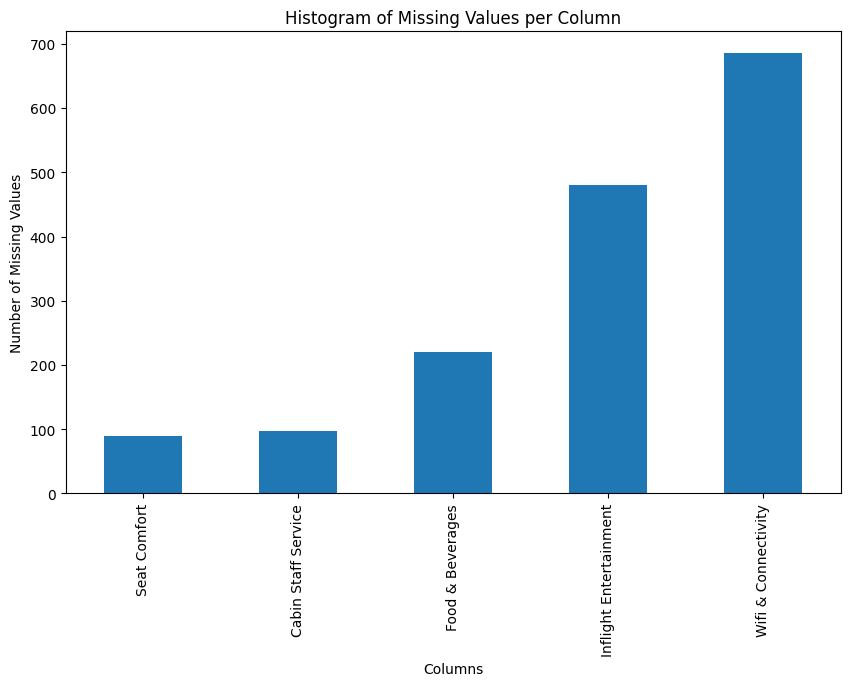

In [253]:
# Calculate the number of missing values per column
missing_values = ba_review.isnull().sum()

# Create a histogram of the missing values
plt.figure(figsize=(10, 6))
missing_values[missing_values > 0].plot(kind='bar')
plt.title('Histogram of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.show()


In [254]:
# List of columns to remove due to the fact they would not be needed for my report or analysis question
columnstoremove = ['Wifi & Connectivity','Inflight Entertainment']
# Remove columns
ba_review = ba_review.drop(columns=columnstoremove)

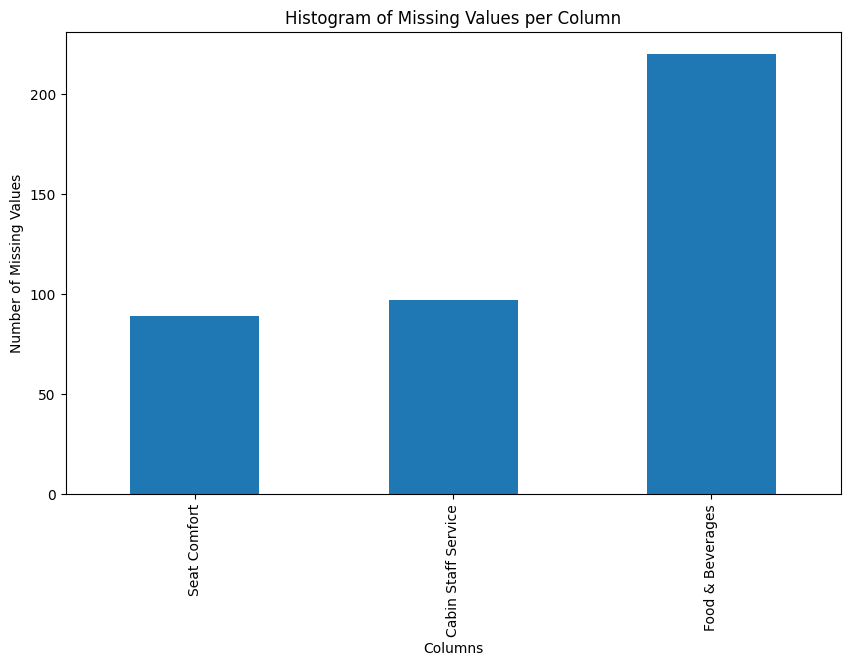

In [255]:
# Calculate the number of missing values per column
missing_values = ba_review.isnull().sum()

# Create a histogram of the missing values
plt.figure(figsize=(10, 6))
missing_values[missing_values > 0].plot(kind='bar')
plt.title('Histogram of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.show()


In [256]:
print(ba_review.isnull().sum())

reviews                  0
recommended              0
Seat Type                0
Seat Comfort            89
Cabin Staff Service     97
Food & Beverages       220
Value For Money          0
dtype: int64


In [257]:
# List of columns to remove due to the fact they would not be needed for my report or analysis question
columnstoremove = ['Food & Beverages']
# Remove columns
ba_review = ba_review.drop(columns=columnstoremove)

In [258]:
print(ba_review.isnull().sum())

reviews                 0
recommended             0
Seat Type               0
Seat Comfort           89
Cabin Staff Service    97
Value For Money         0
dtype: int64


In [259]:
ba_review.dropna(inplace=True)

In [260]:
print(ba_review.isnull().sum())

reviews                0
recommended            0
Seat Type              0
Seat Comfort           0
Cabin Staff Service    0
Value For Money        0
dtype: int64


In [261]:
display(ba_review.head())

,reviews,recommended,Seat Type,Seat Comfort,Cabin Staff Service,Value For Money
0,"| On March 1st, I flew from Berlin to São Pa...",no,Economy Class,3.0,4.0,2
1,| The WORST customer experience! British Airwa...,no,Economy Class,1.0,1.0,1
3,| Flight cancelled with no reason given less t...,no,Economy Class,1.0,1.0,1
4,| This is a route I fly regularly. Used first ...,yes,Business Class,4.0,5.0,3
5,| While BA may have made some positive improv...,no,Economy Class,2.0,2.0,1


In [262]:
# Remove duplicate rows
ba_review.drop_duplicates(inplace=True)

# Display the first few rows to verify the changes
display(ba_review.head())

,reviews,recommended,Seat Type,Seat Comfort,Cabin Staff Service,Value For Money
0,"| On March 1st, I flew from Berlin to São Pa...",no,Economy Class,3.0,4.0,2
1,| The WORST customer experience! British Airwa...,no,Economy Class,1.0,1.0,1
3,| Flight cancelled with no reason given less t...,no,Economy Class,1.0,1.0,1
4,| This is a route I fly regularly. Used first ...,yes,Business Class,4.0,5.0,3
5,| While BA may have made some positive improv...,no,Economy Class,2.0,2.0,1


In [263]:
# Number of Rows and Columns
num_rows, num_cols = ba_review.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

# Data Type
print("\nData types of each column:")
print(ba_review.dtypes)

Number of rows: 903
Number of columns: 6

Data types of each column:
reviews                 object
recommended             object
Seat Type               object
Seat Comfort           float64
Cabin Staff Service    float64
Value For Money          int64
dtype: object


<h1>Visualization</h1>

In [264]:
# Combine seat types into two categories
def map_seat_type(seat_type):
    if seat_type in ['Business Class', 'First Class']:
        return 'First/Business'
    elif seat_type in ['Economy Class', 'Premium Economy']:
        return 'Economy/Premium Economy'
    else:
        return seat_type

ba_review['Seat Type'] = ba_review['Seat Type'].apply(map_seat_type)

# Focus analysis on 'First/Business' and 'Economy/Premium Economy'
ba_review = ba_review[ba_review['Seat Type'].isin(['First/Business', 'Economy/Premium Economy'])]


In [265]:
# Summary statistics for ratings by seat type
summary_stats = ba_review.groupby('Seat Type').agg({
    'Seat Comfort': ['mean', 'std'],
    'Cabin Staff Service': ['mean', 'std'],
    'Value For Money': ['mean', 'std']
}).reset_index()

print(summary_stats)

                 Seat Type Seat Comfort           Cabin Staff Service  \
                                   mean       std                mean   
0  Economy/Premium Economy     2.627208  1.375089            3.021201   
1           First/Business     2.931751  1.359961            3.362018   

            Value For Money            
        std            mean       std  
0  1.503827        2.360424  1.457646  
1  1.519549        2.685460  1.506591  


In [266]:
from textblob import TextBlob

# Function to calculate sentiment polarity
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

ba_review['Sentiment'] = ba_review['reviews'].apply(get_sentiment)

# Average sentiment by seat type
sentiment_stats = ba_review.groupby('Seat Type')['Sentiment'].mean().reset_index()
print(sentiment_stats)

                 Seat Type  Sentiment
0  Economy/Premium Economy   0.050486
1           First/Business   0.096733


In [267]:
# Recommendation analysis
recommendation_stats = ba_review.groupby('Seat Type')['recommended'].value_counts(normalize=True).unstack().fillna(0)
print(recommendation_stats)

recommended                    no       yes
Seat Type                                  
Economy/Premium Economy  0.703180  0.296820
First/Business           0.548961  0.451039


In [268]:
# Reasons for value for money perception
# This might involve deeper text analysis to find common themes
from collections import Counter
import re

def extract_keywords(text):
    # Simple keyword extraction
    keywords = re.findall(r'\b\w+\b', text.lower())
    return keywords

ba_review['keywords'] = ba_review['reviews'].apply(extract_keywords)

# Separate reviews by seat type
first_class_reviews = ba_review[ba_review['Seat Type'] == 'First/Business']['keywords'].sum()
economy_reviews = ba_review[ba_review['Seat Type'] == 'Economy/Premium Economy']['keywords'].sum()

# Count keywords
first_class_keywords = Counter(first_class_reviews)
economy_keywords = Counter(economy_reviews)

# Display most common keywords for each seat type
print("First/Business Class common keywords:", first_class_keywords.most_common(20))
print("Economy/Premium Economy common keywords:", economy_keywords.most_common(20))


First/Business Class common keywords: [('the', 2776), ('and', 1592), ('to', 1578), ('was', 1210), ('a', 1161), ('in', 865), ('i', 801), ('of', 788), ('on', 654), ('flight', 570), ('for', 555), ('ba', 498), ('with', 466), ('is', 457), ('it', 436), ('were', 422), ('not', 421), ('we', 406), ('at', 376), ('class', 367)]
Economy/Premium Economy common keywords: [('the', 4052), ('to', 3180), ('and', 2591), ('i', 1953), ('was', 1905), ('a', 1866), ('in', 1206), ('flight', 1204), ('of', 1120), ('on', 1028), ('for', 990), ('we', 873), ('my', 864), ('with', 803), ('it', 746), ('that', 724), ('they', 697), ('ba', 658), ('not', 655), ('at', 629)]


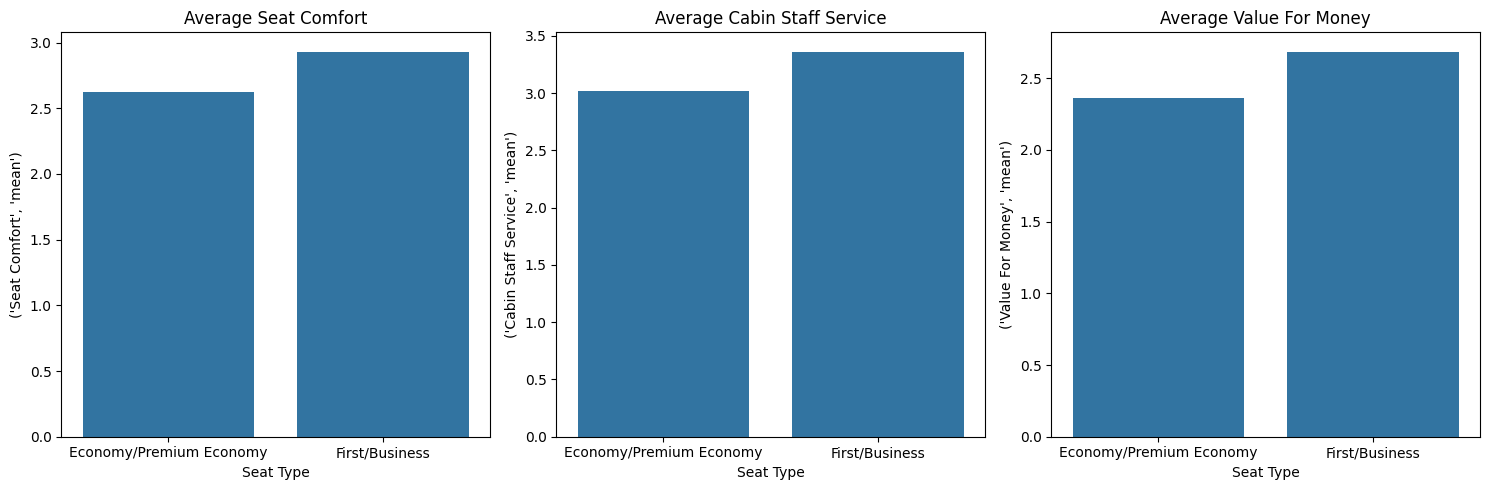

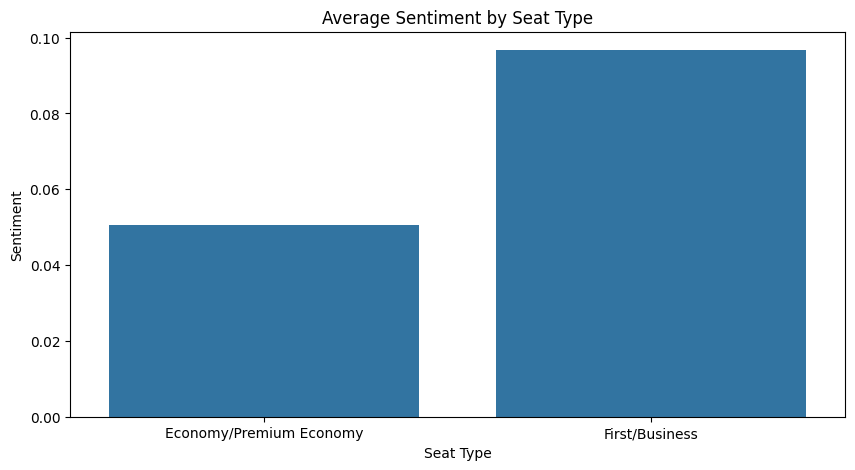

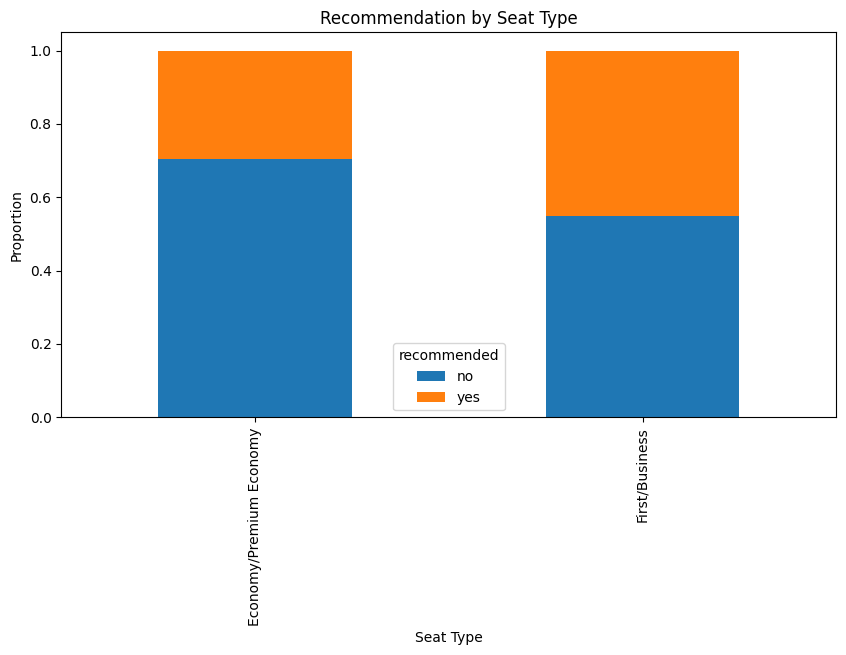

In [269]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize summary statistics
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(data=summary_stats, x='Seat Type', y=('Seat Comfort', 'mean'), ax=axes[0])
axes[0].set_title('Average Seat Comfort')

sns.barplot(data=summary_stats, x='Seat Type', y=('Cabin Staff Service', 'mean'), ax=axes[1])
axes[1].set_title('Average Cabin Staff Service')

sns.barplot(data=summary_stats, x='Seat Type', y=('Value For Money', 'mean'), ax=axes[2])
axes[2].set_title('Average Value For Money')

plt.tight_layout()
plt.show()

# Visualize sentiment analysis
plt.figure(figsize=(10, 5))
sns.barplot(data=sentiment_stats, x='Seat Type', y='Sentiment')
plt.title('Average Sentiment by Seat Type')
plt.show()

# Visualize recommendation analysis
recommendation_stats.plot(kind='bar', stacked=True, figsize=(10, 5))
plt.title('Recommendation by Seat Type')
plt.xlabel('Seat Type')
plt.ylabel('Proportion')
plt.show()


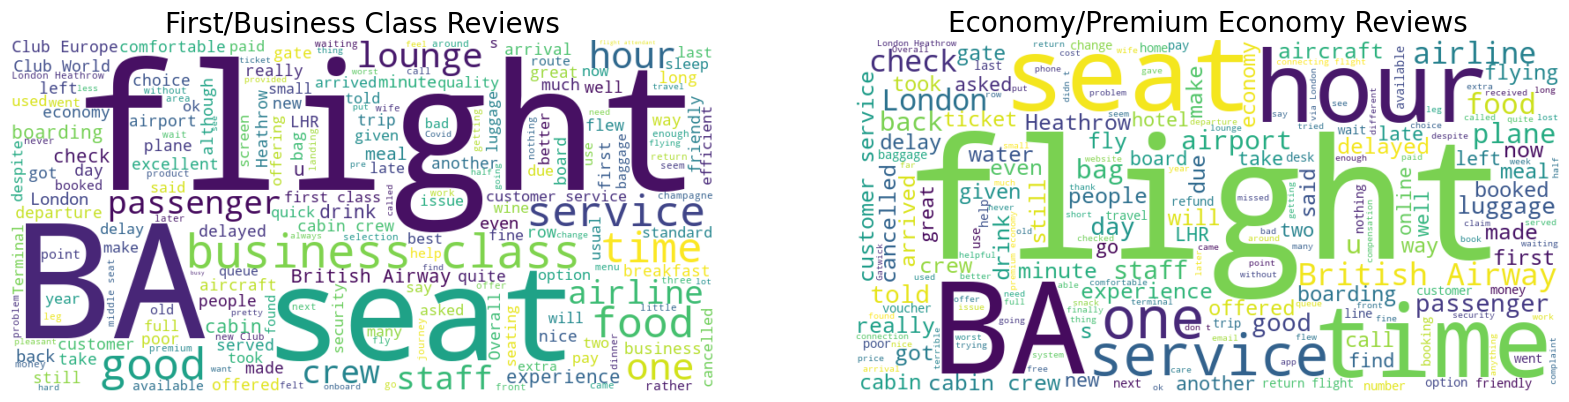

In [270]:
# Function to join all reviews into a single string for each seat type
def get_reviews_text(df, seat_type):
    reviews = df[df['Seat Type'] == seat_type]['reviews']
    return " ".join(reviews)

# Get the text for each seat type
first_business_text = get_reviews_text(ba_review, 'First/Business')
economy_text = get_reviews_text(ba_review, 'Economy/Premium Economy')

# Generate word clouds
first_business_wc = WordCloud(width=800, height=400, background_color='white').generate(first_business_text)
economy_wc = WordCloud(width=800, height=400, background_color='white').generate(economy_text)

# Plot the word clouds
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(first_business_wc, interpolation='bilinear')
ax[0].set_title('First/Business Class Reviews', fontsize=20)
ax[0].axis('off')

ax[1].imshow(economy_wc, interpolation='bilinear')
ax[1].set_title('Economy/Premium Economy Reviews', fontsize=20)
ax[1].axis('off')

plt.show()
